In [0]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import ast

In [0]:
%matplotlib inline
plt.style.use('seaborn-colorblind')

# print(plt.rcParams.keys())

# plt.rcParams['figure.dpi'] = 300
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10.0, 9.0),
          'lines.linewidth': 4,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          'font.family': ['serif'],
          }
for p, v in params.items():
    plt.rcParams[p] = v

Read in our results from each version of the SAT solver from the CSV dumps

In [641]:
dataprefix = Path('sudokusat/results/data/resampled.csv/')
datapaths = [dataprefix/'09-28-16_26_45_results.csv',
             dataprefix/'09-28-16_57_25_results.csv',
             dataprefix/'09-28-21_20_57_results.csv',
            ]
print(datapaths)

[PosixPath('sudokusat/results/data/resampled.csv/09-28-16_26_45_results.csv'), PosixPath('sudokusat/results/data/resampled.csv/09-28-16_57_25_results.csv'), PosixPath('sudokusat/results/data/resampled.csv/09-28-21_20_57_results.csv')]


In [0]:
dfs = []
for datafile in datapaths:
    dfs.append(pd.read_csv(datafile))

In [643]:
for df in dfs: print(df.shape)

(2700, 10)
(2700, 10)
(2700, 10)


In [0]:
results = pd.concat(dfs)

In [645]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8100 entries, 0 to 2699
Data columns (total 10 columns):
Unnamed: 0         8100 non-null int64
backtracks         8100 non-null int64
calls              8100 non-null int64
conclusion         8100 non-null object
correct            8100 non-null bool
heuristic          8100 non-null object
puzzle             8100 non-null object
running_time       8100 non-null float64
simplifications    8100 non-null int64
splits             8100 non-null int64
dtypes: bool(1), float64(1), int64(5), object(3)
memory usage: 640.7+ KB


In [0]:
results.drop('Unnamed: 0', axis='columns', inplace=True)

In [647]:
results.head()

,backtracks,calls,conclusion,correct,heuristic,puzzle,running_time,simplifications,splits
0,11,88,SAT,True,random_split,[[144]],3.443312,215,64
1,10,73,SAT,True,random_split,[[745]],2.754021,165,51
2,0,51,SAT,True,random_split,[[151]],2.958363,105,49
3,1,52,SAT,True,random_split,[[648]],3.167162,125,48
4,1,50,SAT,True,random_split,[[618]],2.659981,121,46


We now do a left join (on 'puzzle') of the original dataset onto the results. This allows us to have more information about the puzzle and the source dataset it originated from.


In [648]:
dataset = pd.read_csv('sudokusat/data/resampled.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 3 columns):
puzzle           2700 non-null object
source           2700 non-null object
starting_info    2700 non-null int64
dtypes: int64(1), object(2)
memory usage: 63.4+ KB


In [0]:
df = results.merge(dataset, how='left', on='puzzle')

In [650]:
df.head()

,backtracks,calls,conclusion,correct,heuristic,puzzle,running_time,simplifications,splits,source,starting_info
0,11,88,SAT,True,random_split,[[144]],3.443312,215,64,resampled,1
1,10,73,SAT,True,random_split,[[745]],2.754021,165,51,resampled,1
2,0,51,SAT,True,random_split,[[151]],2.958363,105,49,resampled,1
3,1,52,SAT,True,random_split,[[648]],3.167162,125,48,resampled,1
4,1,52,SAT,True,random_split,[[648]],3.167162,125,48,resampled,1


In [0]:
def value_variance(puzzle):
    arr = ast.literal_eval(puzzle)
    vals = [y % 10 for x in arr for y in x]
    return np.var(vals)

df['value_variance'] = df.puzzle.apply(value_variance)

In [652]:
df.puzzle.unique().shape, df.puzzle.shape

((2688,), (8178,))

Now we can get a basic idea of the performance averages per heuristic.

In [653]:
df.groupby(['heuristic']).mean()

,backtracks,calls,correct,running_time,simplifications,splits,starting_info,value_variance
heuristic,,,,,,,,
jeroslow_wang_split,70.140499,219.982759,0.904989,2.092795,372.472487,79.298973,13.876742,5.711607
moms_split,0.656640,43.960748,0.999266,3.085499,124.949376,40.654439,13.876742,5.711607
random_split,5.939472,43.152971,0.996332,1.371528,118.124358,29.362436,13.876742,5.711607


We'll also look at the fraction of tests that timed out for each heuristic.


In [654]:
df[df.conclusion == 'TIMEOUT']['heuristic'].value_counts(sort=True) / df.shape[0]

jeroslow_wang_split    0.031670
random_split           0.001223
moms_split             0.000245
Name: heuristic, dtype: float64

Jeroslow-Wang timed out way more often than the other heuristics. But for the rest of the data analysis, let's only consider puzzles for which all three heuristics did not time out (and were correct).


In [655]:
corrects = df.groupby('puzzle').mean()['correct'].reset_index()
print(corrects.shape)
corrects = corrects[corrects.correct == 1.0]
print(corrects.shape)
corrects = corrects.puzzle.values
len(corrects)

(2688, 2)
(2441, 2)


2441

In [656]:
df = df[df.puzzle.isin(corrects)].drop(['correct', 'conclusion'], axis='columns')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7368 entries, 0 to 8177
Data columns (total 10 columns):
backtracks         7368 non-null int64
calls              7368 non-null int64
heuristic          7368 non-null object
puzzle             7368 non-null object
running_time       7368 non-null float64
simplifications    7368 non-null int64
splits             7368 non-null int64
source             7368 non-null object
starting_info      7368 non-null int64
value_variance     7368 non-null float64
dtypes: float64(2), int64(5), object(3)
memory usage: 633.2+ KB


Next, let's look at some properties of the data.

(7368, 10) (2441,)


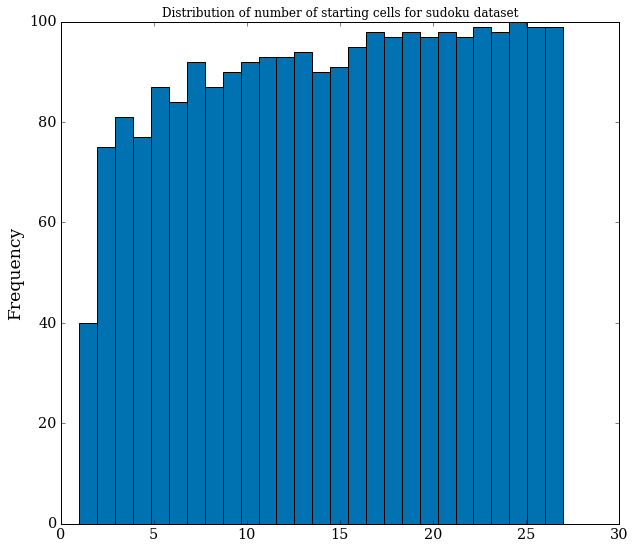

In [657]:
print(df.shape, df.puzzle.unique().shape)
df.groupby('puzzle').mean()['starting_info'].plot(kind='hist', title='Distribution of number of starting cells for sudoku dataset', bins=df.starting_info.unique().shape[0])

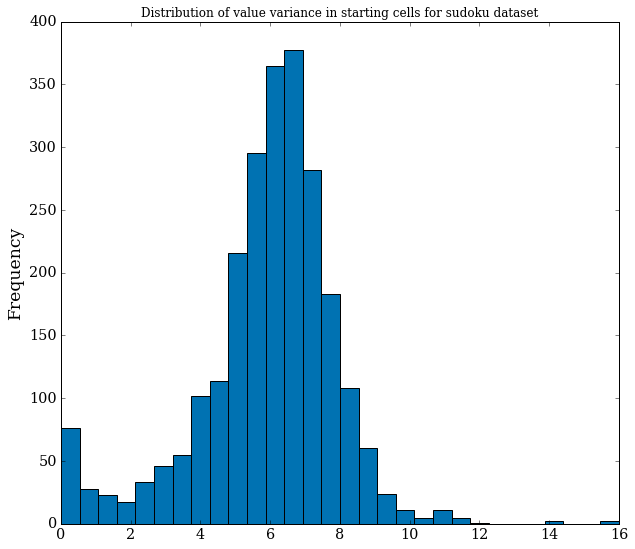

In [658]:
df.groupby('puzzle').mean()['value_variance'].plot(kind='hist', title='Distribution of value variance in starting cells for sudoku dataset', bins=30)

In [659]:
df.describe()

,backtracks,calls,running_time,simplifications,splits,starting_info,value_variance
count,7368.000000,7368.000000,7368.000000,7368.000000,7368.000000,7368.000000,7368.000000
mean,12.678339,63.023887,1.739274,143.811754,35.667210,14.680782,5.878565
std,44.891571,133.985297,2.129538,218.688135,47.650292,7.610560,2.027287
min,0.000000,2.000000,0.087649,13.000000,0.000000,1.000000,0.000000
25%,0.000000,15.000000,0.401603,62.000000,11.000000,8.000000,5.098171
50%,1.000000,28.000000,0.935288,90.000000,22.000000,15.000000,6.177515
75%,4.000000,52.000000,2.068792,136.000000,42.000000,21.000000,7.086031
max,400.000000,1210.000000,15.484811,2946.000000,413.000000,27.000000,16.000000


Okay, now let's look at some trends.


In [660]:
df.corr()

,backtracks,calls,running_time,simplifications,splits,starting_info,value_variance
backtracks,1.000000,0.986836,0.346261,0.967985,0.890621,-0.106829,-0.040517
calls,0.986836,1.000000,0.485614,0.985989,0.952441,-0.224379,-0.091705
running_time,0.346261,0.485614,1.000000,0.506242,0.713042,-0.664600,-0.339951
simplifications,0.967985,0.985989,0.506242,1.000000,0.948563,-0.233030,-0.087892
splits,0.890621,0.952441,0.713042,0.948563,1.000000,-0.429630,-0.181518
starting_info,-0.106829,-0.224379,-0.664600,-0.233030,-0.429630,1.000000,0.384114
value_variance,-0.040517,-0.091705,-0.339951,-0.087892,-0.181518,0.384114,1.000000


In [680]:
print(df.corr()[['starting_info', 'value_variance']].T.to_latex(bold_rows=True, float_format="{:0.2f}".format))

\begin{tabular}{lrrrrrrr}
\toprule
{} &  backtracks &  calls &  running\_time &  simplifications &  splits &  starting\_info &  value\_variance \\
\midrule
\textbf{starting\_info } &       -0.11 &  -0.22 &         -0.66 &            -0.23 &   -0.43 &           1.00 &            0.38 \\
\textbf{value\_variance} &       -0.04 &  -0.09 &         -0.34 &            -0.09 &   -0.18 &           0.38 &            1.00 \\
\bottomrule
\end{tabular}



In [661]:
df.head()

,backtracks,calls,heuristic,puzzle,running_time,simplifications,splits,source,starting_info,value_variance
0,11,88,random_split,[[144]],3.443312,215,64,resampled,1,0.0
1,10,73,random_split,[[745]],2.754021,165,51,resampled,1,0.0
6,0,52,random_split,[[155]],3.353546,119,50,resampled,1,0.0
8,4,70,random_split,[[199]],3.196045,140,60,resampled,1,0.0
9,4,70,random_split,[[199]],3.196045,140,60,resampled,1,0.0


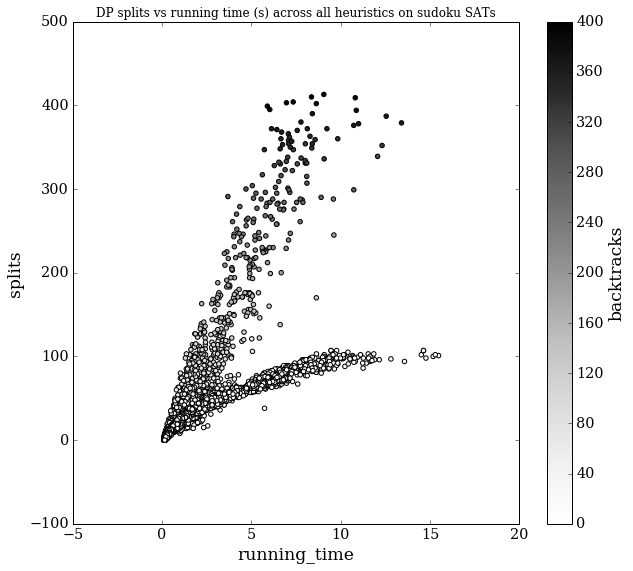

In [662]:
df[['running_time', 'calls', 'backtracks', 'splits', 'simplifications']].plot(kind='scatter', x='running_time', y='splits', c='backtracks', title='DP splits vs running time (s) across all heuristics on sudoku SATs')

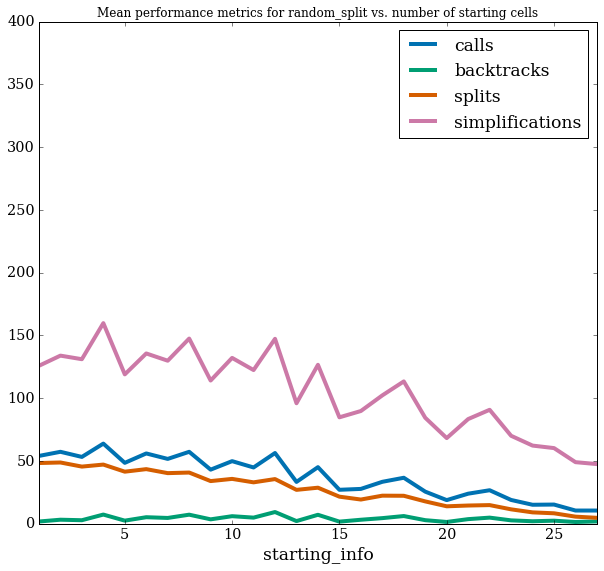

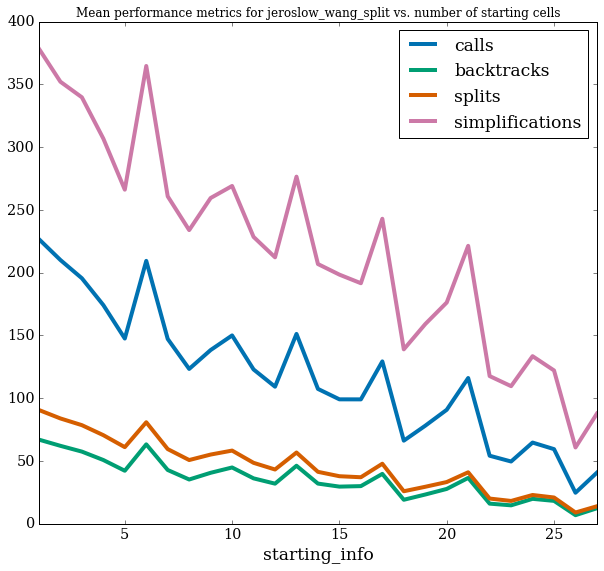

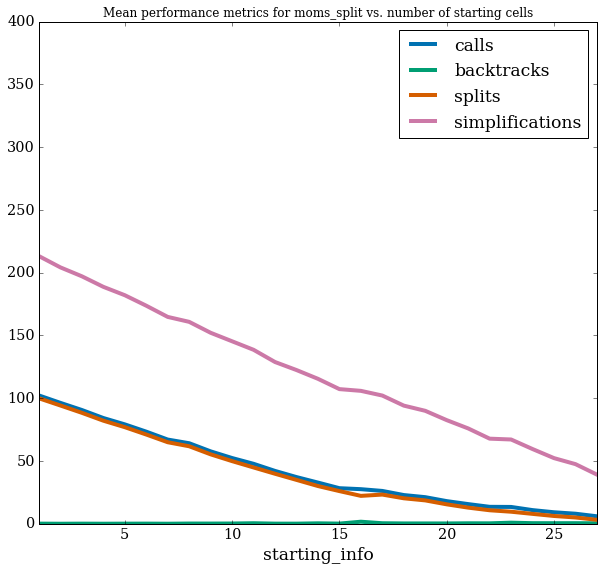

In [663]:
for heur in df.heuristic.unique():
    df[df.heuristic == heur].groupby('starting_info').mean()[['calls', 'backtracks', 'splits', 'simplifications']].plot(ylim=(0, 400), title=f'Mean performance metrics for {heur} vs. number of starting cells')

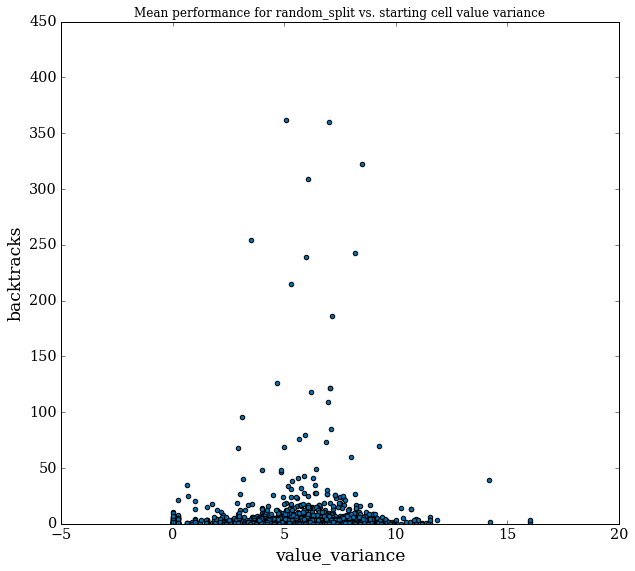

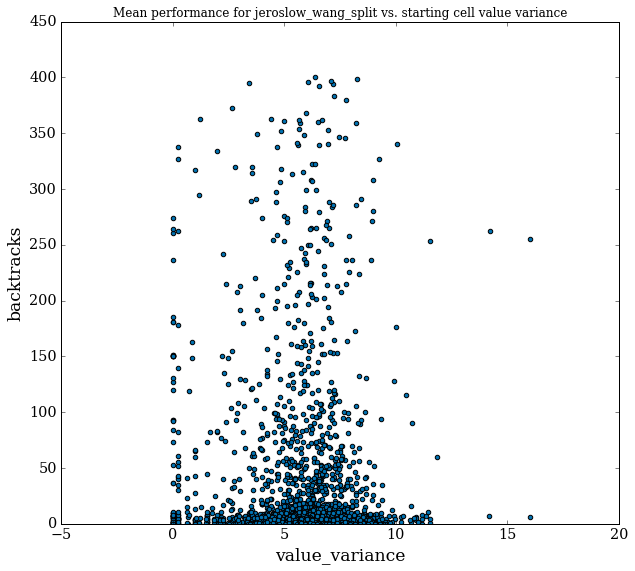

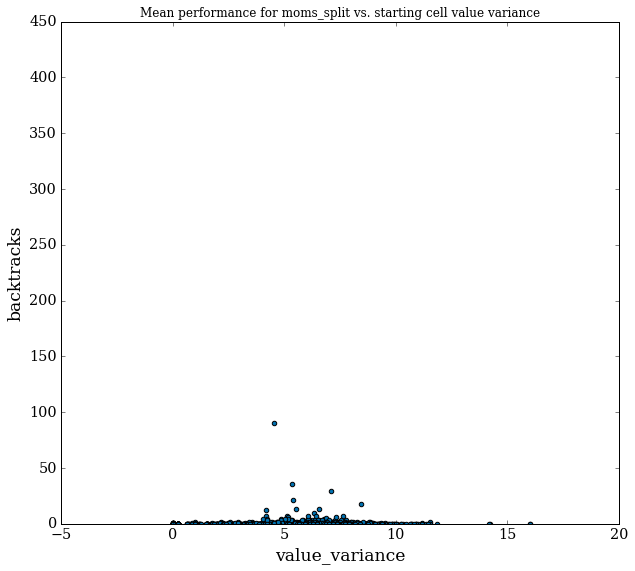

In [664]:
for heur in df.heuristic.unique():
    df[df.heuristic == heur].plot(kind='scatter', x='value_variance', y='backtracks', ylim=(0,450), title=f'Mean performance for {heur} vs. starting cell value variance')

Those results are pretty surprising, so perhaps we need to contrast with the general SAT problems and see hwo they do.

In [665]:
dataprefix = Path('sudokusat/results/data/general.csv/')
datapaths = [dataprefix/'09-29-10_21_19_results.csv',
            dataprefix/'09-29-20_25_17_results.csv',
            dataprefix/'09-29-12_34_03_results.csv',
            ]

print(datapaths)

dfs = []
for datafile in datapaths:
    dfs.append(pd.read_csv(datafile))

for dframe in dfs: print(dframe.shape)

results2 = pd.concat(dfs).drop('Unnamed: 0', axis=1)


[PosixPath('sudokusat/results/data/general.csv/09-29-10_21_19_results.csv'), PosixPath('sudokusat/results/data/general.csv/09-29-20_25_17_results.csv'), PosixPath('sudokusat/results/data/general.csv/09-29-12_34_03_results.csv')]
(3199, 10)
(3199, 10)
(3199, 10)


In [666]:
results2.head()

,backtracks,calls,conclusion,correct,heuristic,problem,running_time,simplifications,splits
0,18,56,UNSAT,True,moms_split,data/satlib/uniform/UUF50.218.1000/uuf50-0410.cnf,9.435179,159,18
1,17,53,UNSAT,True,moms_split,data/satlib/uniform/UUF50.218.1000/uuf50-0376.cnf,8.642038,116,17
2,29,89,UNSAT,True,moms_split,data/satlib/uniform/UUF50.218.1000/uuf50-0362.cnf,15.894175,244,29
3,33,101,UNSAT,True,moms_split,data/satlib/uniform/UUF50.218.1000/uuf50-0404.cnf,17.482114,250,33
4,30,92,UNSAT,True,moms_split,data/satlib/uniform/UUF50.218.1000/uuf50-0438.cnf,16.144455,216,30


In [667]:
dataset2 = pd.read_csv('sudokusat/data/general.csv')
dataset2.head()

,file,source
0,data/satlib/uniform/.DS_Store,satlib_uniform
1,data/satlib/uniform/UUF50.218.1000,satlib_uniform
2,data/satlib/uniform/uf50-218,satlib_uniform
3,data/satlib/uniform/UUF75.325.100,satlib_uniform
4,data/satlib/uniform/UUF50.218.1000/uuf50-0410.cnf,satlib_uniform


In [668]:
df2 = results2.merge(dataset2, how='left', left_on='problem', right_on='file')
df2.head()

,backtracks,calls,conclusion,correct,heuristic,problem,running_time,simplifications,splits,file,source
0,18,56,UNSAT,True,moms_split,data/satlib/uniform/UUF50.218.1000/uuf50-0410.cnf,9.435179,159,18,data/satlib/uniform/UUF50.218.1000/uuf50-0410.cnf,satlib_uniform
1,17,53,UNSAT,True,moms_split,data/satlib/uniform/UUF50.218.1000/uuf50-0376.cnf,8.642038,116,17,data/satlib/uniform/UUF50.218.1000/uuf50-0376.cnf,satlib_uniform
2,29,89,UNSAT,True,moms_split,data/satlib/uniform/UUF50.218.1000/uuf50-0362.cnf,15.894175,244,29,data/satlib/uniform/UUF50.218.1000/uuf50-0362.cnf,satlib_uniform
3,33,101,UNSAT,True,moms_split,data/satlib/uniform/UUF50.218.1000/uuf50-0404.cnf,17.482114,250,33,data/satlib/uniform/UUF50.218.1000/uuf50-0404.cnf,satlib_uniform
4,30,92,UNSAT,True,moms_split,data/satlib/uniform/UUF50.218.1000/uuf50-0438.cnf,16.144455,216,30,data/satlib/uniform/UUF50.218.1000/uuf50-0438.cnf,satlib_uniform


In [669]:
df2.groupby('conclusion').mean()

,backtracks,calls,correct,running_time,simplifications,splits
conclusion,,,,,,
SAT,46.043440,235.649870,True,12.458270,549.635969,141.724587
TIMEOUT,1040.209050,3082.418099,False,30.053148,5799.413950,1040.209050
UNSAT,29.693058,91.079173,True,12.727836,212.015953,29.693058


In [670]:
df2.groupby('source').mean()

,backtracks,calls,correct,running_time,simplifications,splits
source,,,,,,
satlib_graph,366.404610,1089.616318,0.663027,23.729971,1776.012739,371.668790
satlib_uniform,668.249048,1997.966508,0.373016,20.838804,3943.750000,682.974921


In [671]:
df2.groupby('heuristic').mean()

,backtracks,calls,correct,running_time,simplifications,splits
heuristic,,,,,,
jeroslow_wang_split,704.87965,2101.004689,0.312285,19.713326,3201.237262,704.879650
moms_split,36.58362,139.804939,0.997187,17.215135,329.404189,64.901532
random_split,952.19256,2816.912785,0.108471,28.567687,6066.463582,958.300719


In [672]:
hperf = df2.groupby('heuristic').mean()
hperf['backtracks/split'] = hperf.backtracks / hperf.splits

print(hperf.groupby('heuristic').mean().to_latex(bold_rows=True, float_format="{:0.2f}".format))

\begin{tabular}{lrrrrrrr}
\toprule
{} &  backtracks &   calls &  correct &  running\_time &  simplifications &  splits &  backtracks/split \\
\textbf{heuristic          } &             &         &          &               &                  &         &                   \\
\midrule
\textbf{jeroslow\_wang\_split} &      704.88 & 2101.00 &     0.31 &         19.71 &          3201.24 &  704.88 &              1.00 \\
\textbf{moms\_split         } &       36.58 &  139.80 &     1.00 &         17.22 &           329.40 &   64.90 &              0.56 \\
\textbf{random\_split       } &      952.19 & 2816.91 &     0.11 &         28.57 &          6066.46 &  958.30 &              0.99 \\
\bottomrule
\end{tabular}



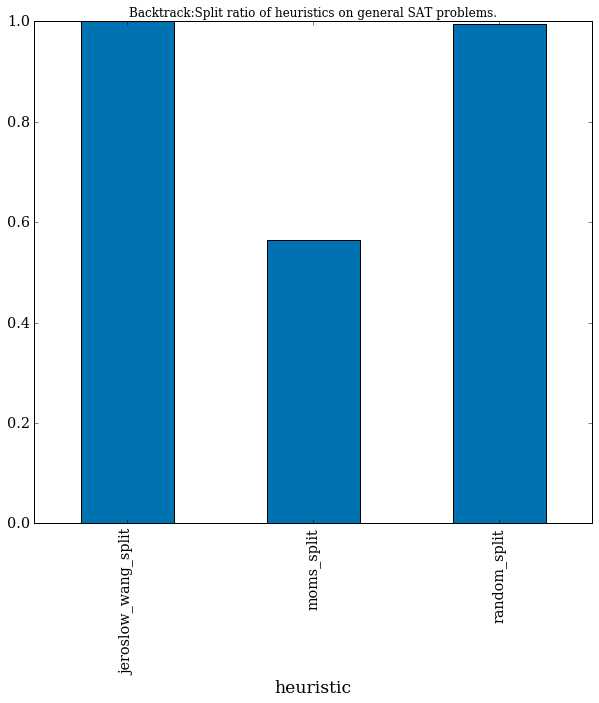

In [673]:
hperf = df2.groupby('heuristic').mean()
hperf['backtracks_per_split'] = hperf.backtracks / hperf.splits
hperf['backtracks_per_split'].plot(kind='bar', title='Backtrack:Split ratio of heuristics on general SAT problems.')

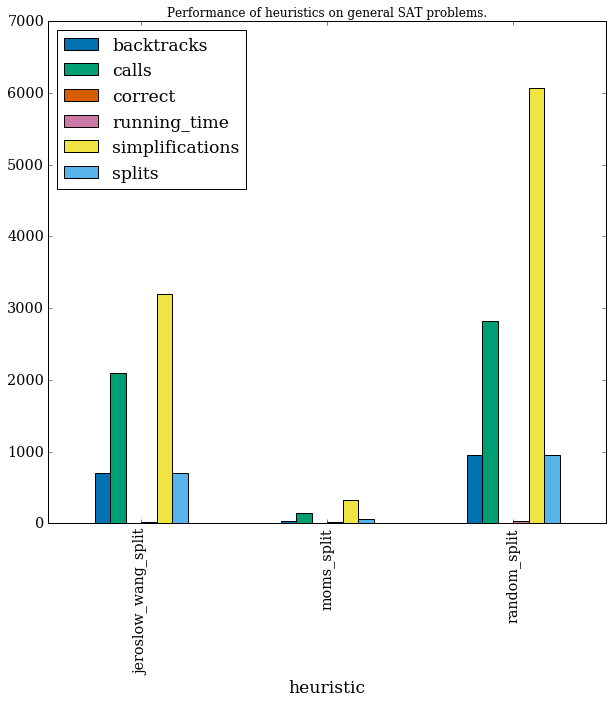

In [674]:
df2.groupby('heuristic').mean().plot(kind='bar', title='Performance of heuristics on general SAT problems.')